# Libraries importation

In [1]:
import numpy as np
import pandas as pd
import os
import librosa
from keras.models import Sequential
from keras.layers import TimeDistributed, Dense, LSTM, Flatten
import matplotlib.pyplot as plt

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16242878520610419152
xla_global_id: -1
]


# Data preprocessing

In [6]:
#Pronunciation variants for one command
diff_command_variants = 11

In [7]:
def extract_mfcc(audio_path, n_mfcc=13, n_fft=2048, hop_length=512):
    audio, sr = librosa.load(audio_path, sr=None)

    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    return mfccs

In [30]:
def preprocess_data(folder_path, diff_variants=diff_command_variants):
    train_features = []
    train_labels = []
    val_features = []
    val_labels = []
    
    command_counter = 0
    
    for i, file_path in enumerate(sorted(os.listdir(folder_path))):
        mfccs = extract_mfcc(folder_path + '/' + file_path)

        empty_label = [0,0,0,0,0]
        empty_label[command_counter] = 1
        if diff_variants <= 2:
            val_features.append(mfccs[:,:80])
            val_labels.append(empty_label)
        else:
            train_features.append(mfccs[:,:80])
            train_labels.append(empty_label)
        
        diff_variants -= 1
        if diff_variants == 0:
            command_counter += 1
            diff_variants = diff_command_variants

    train_features = np.array(train_features)
    train_labels = np.array(train_labels)
    val_features = np.array(val_features)
    val_labels = np.array(val_labels)
        
    return train_features, train_labels, val_features, val_labels

In [32]:
train_x, train_Y, val_x, val_Y = preprocess_data('/kaggle/input/spoken-commands-extended/words')
label_names = ['izbrisi', 'krug', 'kvadrat', 'oboji', 'trougao']

In [34]:
def plot_mfccs(train_x, label_names):
    j = 0
    for i in range(train_x.shape[0]//(diff_command_variants-1)):
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(train_x[i], x_axis='time', cmap='viridis')
        plt.colorbar()
        plt.title(label_names[j])
        plt.xlabel('Time')
        plt.ylabel('MFCC Coefficient')
        plt.show()
        j += 1

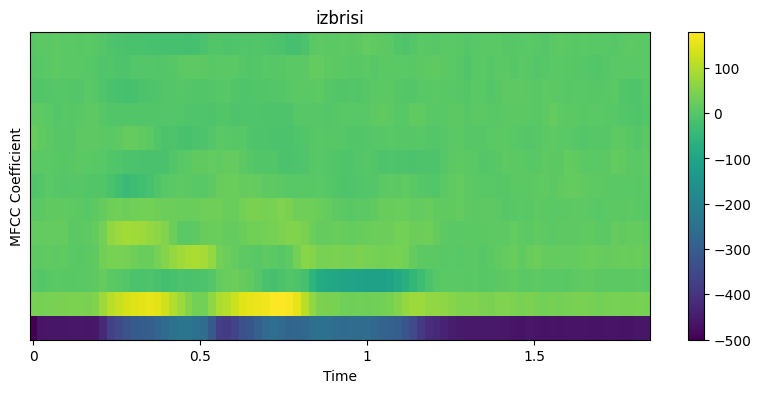

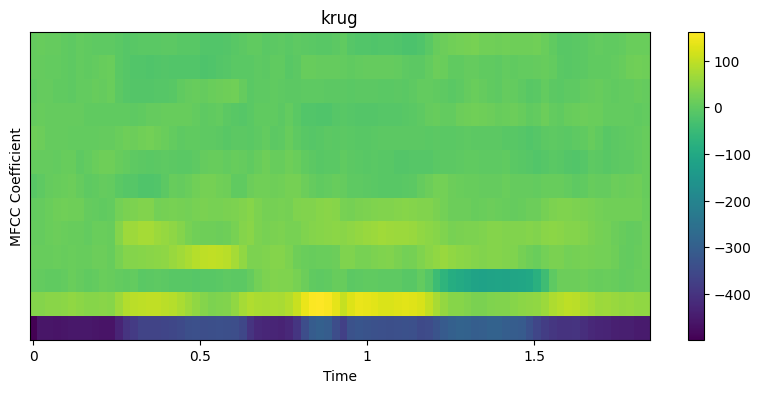

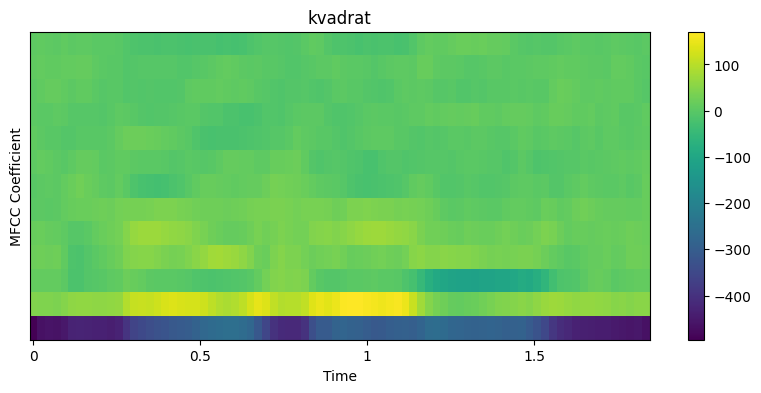

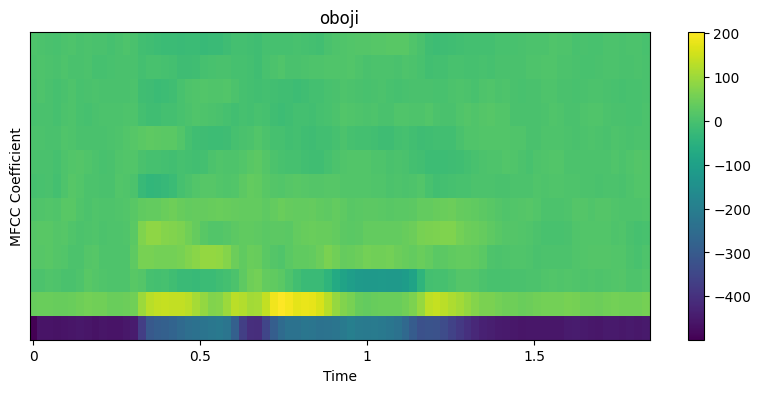

In [35]:
plot_mfccs(train_x, label_names)

# Model

In [21]:
def build_model():
    model = Sequential()
    #model.add(TimeDistributed(Dense(64, activation='relu'), input_shape=(13, 80)))

    #model.add(LSTM(64, return_sequences=True))
    #model.add(LSTM(64))
    #model.add(Dense(5, activation='softmax'))
    model.add(Flatten(input_shape=(13, 80)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [22]:
def train(model, train, val, epochs = 10, batch_size = 5):
    history = model.fit(
        x=train[0],
        y=train[1],
        batch_size=batch_size,
        epochs=epochs,
        validation_data=val
    )
    
    return history

In [36]:
model = build_model()

In [37]:
history = train(model, (train_x, train_Y), (val_x, val_Y))

Epoch 1/10
9/9 [==============================] - 1s 30ms/step - loss: 73.6525 - accuracy: 0.2889 - val_loss: 31.9695 - val_accuracy: 0.3000
Epoch 2/10
9/9 [==============================] - 0s 8ms/step - loss: 29.1708 - accuracy: 0.3556 - val_loss: 5.6564 - val_accuracy: 0.8000
Epoch 3/10
9/9 [==============================] - 0s 8ms/step - loss: 6.0866 - accuracy: 0.7778 - val_loss: 22.2850 - val_accuracy: 0.3000
Epoch 4/10
9/9 [==============================] - 0s 7ms/step - loss: 4.7493 - accuracy: 0.7556 - val_loss: 12.0803 - val_accuracy: 0.6000
Epoch 5/10
9/9 [==============================] - 0s 9ms/step - loss: 6.5665 - accuracy: 0.8000 - val_loss: 11.2964 - val_accuracy: 0.5000
Epoch 6/10
9/9 [==============================] - 0s 8ms/step - loss: 13.3308 - accuracy: 0.6667 - val_loss: 22.6794 - val_accuracy: 0.6000
Epoch 7/10
9/9 [==============================] - 0s 7ms/step - loss: 7.2317 - accuracy: 0.8222 - val_loss: 12.6553 - val_accuracy: 0.6000
Epoch 8/10
9/9 [========

In [39]:
def plot_model_loss(history, title):
    plt.title(title)
    plt.plot(history.history['val_loss'], label="Val_loss")
    plt.plot(history.history['loss'], label="Loss")
    plt.legend()
    plt.show()

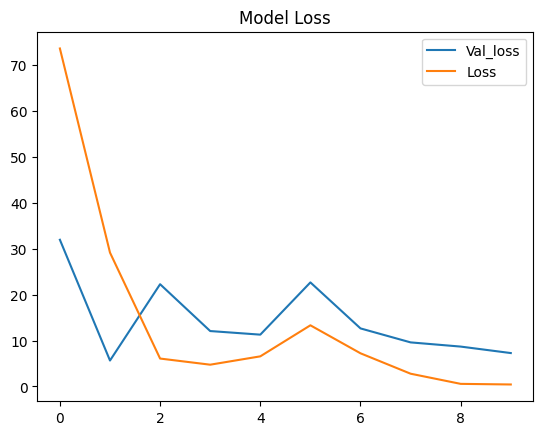

In [40]:
plot_model_loss(history, "Model Loss")

In [41]:
def plot_model_accuracy(history, title):
    plt.title(title)
    plt.plot(history.history['val_accuracy'], label="Val_accuracy")
    plt.plot(history.history['accuracy'], label="Accuracy")
    plt.legend()
    plt.show()

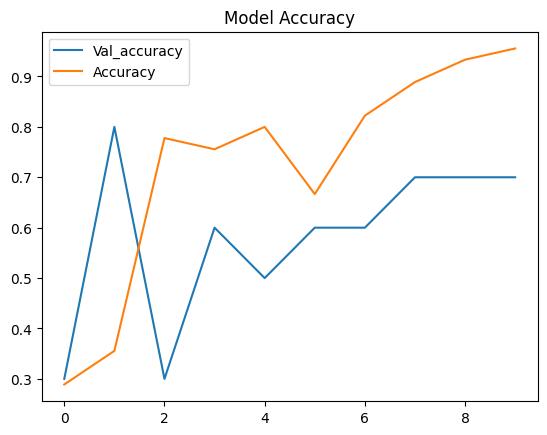

In [42]:
plot_model_accuracy(history, "Model Accuracy")

In [44]:
model.save('/kaggle/working/model.h5')